In [ ]:
import sys
import pandas as pd
import numpy as np
import plotly.express as px
import plotly as py
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from PIL import Image

import pandas as pd
from pathlib import Path

import calendar
!pip install termcolor
from termcolor import colored
from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

In [ ]:
df= pd.read_csv("Data collected Jan-Aug 2024.csv")
df.head(5)

,Transaction ID,Date,Customer ID,Product ID,Product Category,Quantity,Price per Unit,Total Amount,Payment Method,Store Location,Customer Age,Customer Gender,Day of the Week,Promotion Applied
0,1053,8/31/2024,C496,P098,Snacks,6,4.77,28.62,Mobile Payment,Kampala,54,Male,Saturday,No
1,1350,8/31/2024,C883,P049,Beverages,6,3.18,19.08,Mobile Payment,Kampala,58,Female,Saturday,Yes
2,1633,8/31/2024,C917,P046,Vegetables,3,8.76,26.28,Mobile Payment,Nansana,33,Female,Saturday,No
3,1834,8/31/2024,C425,P041,Dairy,7,4.38,30.66,Mobile Payment,Nansana,43,Female,Saturday,No
4,2423,8/31/2024,C059,P007,Beverages,2,4.19,8.38,Mobile Payment,Kampala,49,Male,Saturday,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Transaction ID     5000 non-null   int64  
 1   Date               5000 non-null   object 
 2   Customer ID        5000 non-null   object 
 3   Product ID         5000 non-null   object 
 4   Product Category   5000 non-null   object 
 5   Quantity           5000 non-null   int64  
 6   Price per Unit     5000 non-null   float64
 7   Total Amount       5000 non-null   float64
 8   Payment Method     5000 non-null   object 
 9   Store Location     5000 non-null   object 
 10  Customer Age       5000 non-null   int64  
 11  Customer Gender    5000 non-null   object 
 12  Day of the Week    5000 non-null   object 
 13  Promotion Applied  5000 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 547.0+ KB


In [ ]:
print("Number of rows in dataset is: ", df.shape[0])
print("Number of columns in dataset is: ", df.shape[1])

Number of rows in dataset is:  5000
Number of columns in dataset is:  14


#prepare, cleanse the data

##Data cleaning
We need to make sure the data is clean before starting your analysis. As a reminder, we should check for:



*   Duplicate records
*   Consistent formatting
*   Missing values (Remove the canceled order)
*   Obviously wrong values (Remove the transaction with negative quantity)











**Duplicate Records**

*   How many duplicate transaction records are there?






In [ ]:
print('Duplicate entries: {}'.format(df.duplicated().sum()))
print('{}% rows are duplicate.'.format(round((df.duplicated().sum()/df.shape[0])*100),2))
#Remove duplicate data
df.drop_duplicates(inplace = True)

Duplicate entries: 0
0% rows are duplicate.


**Consistent formatting**

In [ ]:
df['Customer ID'] = df['Customer ID'].astype(str)

In [ ]:
df.describe()

,Transaction ID,Quantity,Price per Unit,Total Amount,Customer Age
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,3500.500000,4.993000,5.273104,26.218548,41.154800
std,1443.520003,2.556141,2.748093,20.376776,13.493096
min,1001.000000,1.000000,0.500000,0.540000,18.000000
25%,2250.750000,3.000000,2.890000,9.357500,30.000000
50%,3500.500000,5.000000,5.310000,20.645000,41.500000
75%,4750.250000,7.000000,7.670000,38.480000,53.000000
max,6000.000000,9.000000,10.000000,89.910000,64.000000


Checking the total number of products, transactions and customers.

In [ ]:
pd.DataFrame([{'products': len(df['Product ID'].value_counts()),
               'transactions': len(df['Transaction ID'].value_counts()),
               'customers': len(df['Customer ID'].unique().tolist()),
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,100,5000,987


**Removing transaction with missing Customer ID**

We find out that CustomerID values are missing for those customers which have negative quantity values. Therefore, we will remove them too.

In [ ]:
df = df[df['Customer ID'].notna()]

**Obviously wrong values**

Remove transaction with negative values for price and quantity

In [ ]:
print("Total number of transaction with negative quantity:", df[df['Quantity'] <= 0 ]['Quantity'].count())
print("Precentage of transactions with zero or negative quantity" ,round(len(df[df['Quantity']<=0])/len(df)*100, 2),"%")
print("Total number of transaction with negative Price:", df[df['Price per Unit'] <= 0 ]['Price per Unit'].count())
print("Precentage of transactions with zero or negative price" ,round(len(df[df['Price per Unit']<=0])/len(df)*100, 2),"%")

Total number of transaction with negative quantity: 0
Precentage of transactions with zero or negative quantity 0.0 %
Total number of transaction with negative Price: 0
Precentage of transactions with zero or negative price 0.0 %


In [ ]:
df = df[(df['Price per Unit'] > 0) & (df['Quantity'] > 0)]

In [ ]:
print("Number of rows in dataset is: ", df.shape[0])
print("Number of columns in dataset is: ", df.shape[1])

Number of rows in dataset is:  5000
Number of columns in dataset is:  14


**Create Recency Frequency Monetary (RFM) table**

RFM is abasic customer segmentation algorithm based on their purchasing behaviour. The behaviour is identified by using only three customer data points:

Recency: the recency of purchase/ How many days ago was their last purchase?

Frequency: the frequency of purchases/ total number of purchases/How many times has the customer purchased from our store?

Monetary: the mean monetary value of each purchase/the amount they have spent/How much has this customer spent? Again limit to last two years – or take all time The RFM Analysis will help the businesses to segment their customer base into different homogenous groups so that they can engage with each group with different targeted marketing strategies. Sometime RFM is also used to identify the High-Value Customers (HVCs).

In [ ]:
print('Start date:' , df['Date'].min())
print('End date:' , df['Date'].max())

Start date: 1/1/2024
End date: 8/9/2024


In [ ]:
# Create revenue colummn
df['Revenue'] = df['Price per Unit'] * df['Quantity']
# Convert to show date only
from datetime import datetime
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.date

In [ ]:
import datetime as dt
snapshot_date = max(df.Date) + dt.timedelta(days=1)

In [ ]:
# RFM table
# Aggregate data by each customer
rfm = df.groupby('Customer ID').agg({'Date': lambda x: (snapshot_date - x.max()).days, 'Transaction ID': lambda x: len(x), 'Revenue': lambda x: x.sum()}).reset_index()
rfm['Date'] = rfm['Date'].astype(int)

# Rename columns
rfm.rename(columns={'Date': 'Recency',
                         'Transaction ID': 'Frequency',
                         'Revenue': 'MonetaryValue'}, inplace=True)

In [ ]:
rfm.head()

,Customer ID,Recency,Frequency,MonetaryValue
0,C001,51,7,246.42
1,C002,6,3,126.30
2,C003,25,5,217.36
3,C004,59,3,85.00
4,C005,58,5,202.26


Right now, the dataset consists of recency, frequency, and monetary value column. But we cannot use the dataset yet because we have to preprocess the data more.

**Manage Skewness and Scaling**

We have to make sure that the data meet these assumptions:

The data should meet assumptions where the variables are not skewed and have the same mean and variance.

Because of that, we have to manage the skewness of the variables. Here are the visualizations of each variable.

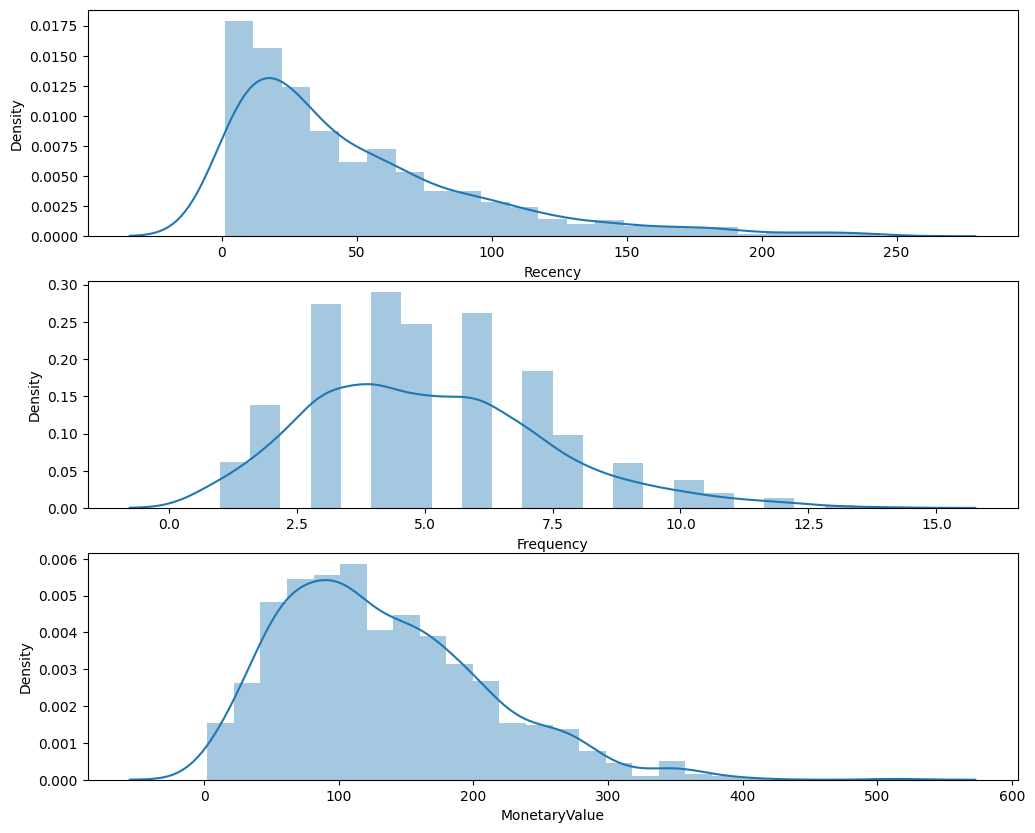

In [ ]:
plt.figure(figsize=(12,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(rfm['MonetaryValue'])

# Show the plot
plt.show()

To address skewness in the dataset and achieve a more symmetrical distribution, several transformation techniques can be applied. These include:

Log Transformation: Useful for reducing right-skewness, particularly for variables with a wide range of positive values.
Square Root Transformation: Effective for moderate skewness, especially for variables where differences between smaller values are more significant.
Box-Cox Transformation: A flexible method applicable to variables with strictly positive values, allowing for optimization of the power parameter to achieve symmetry.
It is important to note that these transformations are only applicable if the variable in question contains strictly positive values.

In [ ]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(rfm[x], ax=ax[0,0])
    sns.distplot(np.log(rfm[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(rfm[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(rfm[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()

#     print(rfm[x].skew().round(2))
#     print(np.log(rfm[x]).skew().round(2))
#     print(np.sqrt(rfm[x]).skew().round(2))
#     print(pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))

    print('Log Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.log(rfm[x]).skew().round(2))
    print('Square Root Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.sqrt(rfm[x]).skew().round(2))
    print('Box-Cox Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))

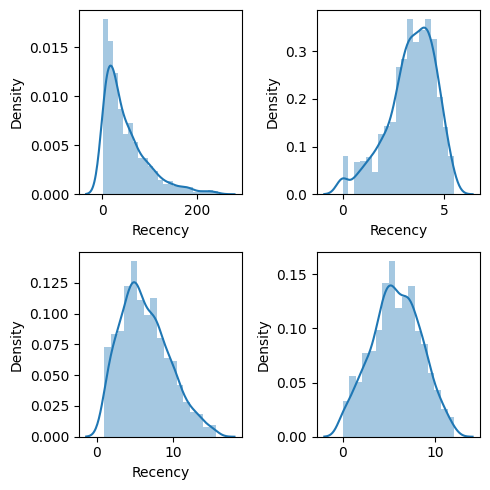

Log Transform : The skew coefficient of 1.52 to -0.77
Square Root Transform : The skew coefficient of 1.52 to 0.51
Box-Cox Transform : The skew coefficient of 1.52 to -0.06


In [ ]:
analyze_skewness('Recency')

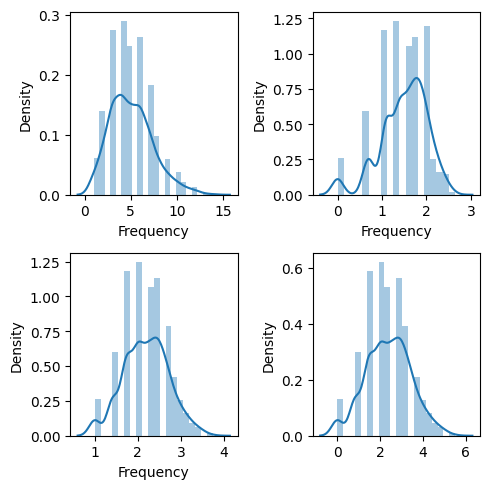

Log Transform : The skew coefficient of 0.61 to -0.77
Square Root Transform : The skew coefficient of 0.61 to -0.03
Box-Cox Transform : The skew coefficient of 0.61 to -0.02


In [ ]:
analyze_skewness('Frequency')

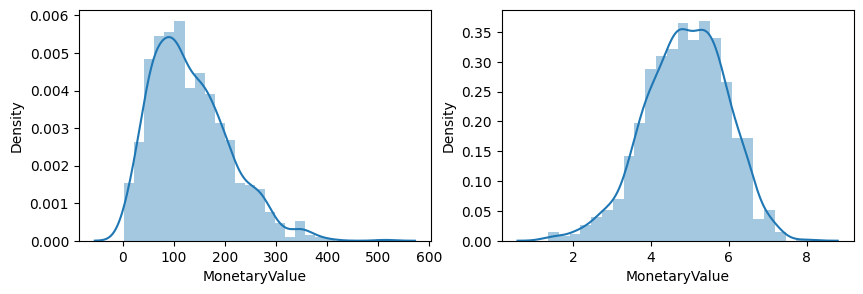

0.82
-0.29


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(rfm['MonetaryValue'], ax=ax[0])
sns.distplot(np.cbrt(rfm['MonetaryValue']), ax=ax[1])
plt.show()
print(rfm['MonetaryValue'].skew().round(2))
print(np.cbrt(rfm['MonetaryValue']).skew().round(2))

In [ ]:
pd.Series(np.cbrt(rfm['MonetaryValue'])).values

array([6.26939045, 5.01727359, 6.01256626, 4.39682967, 5.86998062,
       5.18022569, 4.10235835, 5.55482361, 4.82916274, 5.93674284,
       4.3652217 , 5.52331699, 7.06410502, 5.61298009, 3.85389497,
       4.43053825, 5.4048653 , 4.55568665, 6.29649591, 3.54897147,
       4.75587454, 6.3460471 , 1.88144449, 3.42279948, 7.08010033,
       5.19755802, 3.94251105, 4.04062762, 4.89612355, 4.68830653,
       4.66912003, 4.27484867, 3.6121503 , 2.07931314, 5.2094994 ,
       4.29445834, 3.6741811 , 3.69870907, 5.27667452, 4.51942222,
       4.29246924, 4.53081728, 4.87671866, 5.10804829, 5.65091744,
       4.56706149, 3.8949749 , 4.65962089, 5.08107816, 5.58116547,
       3.47050036, 4.72098658, 3.38424079, 5.57269875, 1.47972724,
       5.95973033, 3.82130233, 5.37618687, 5.89003393, 3.80226089,
       5.29742369, 4.38195086, 4.60415504, 4.96887329, 5.89838125,
       4.86604316, 3.96638497, 5.9149101 , 6.29279431, 3.51098589,
       5.31588919, 5.34743231, 6.7225497 , 4.89973621, 3.69162

In [ ]:
# Set the Numbers
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(rfm['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(rfm['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(rfm['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
982,8.811348,0.829554,4.396830
983,8.299294,1.467360,4.778463
984,5.793179,2.480508,3.421661
985,7.273324,0.000000,2.743511
986,7.273324,2.005739,3.659057


In [ ]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[0. 0. 0.]
[1. 1. 1.]


In [ ]:
pd.DataFrame(customers_normalized).head()

,0,1,2
0,0.383566,0.868495,1.325481
1,-1.315202,-0.866486,0.116787
2,-0.288067,0.089903,1.077563
3,0.536541,-0.866486,-0.482141
4,0.518299,0.089903,0.939922


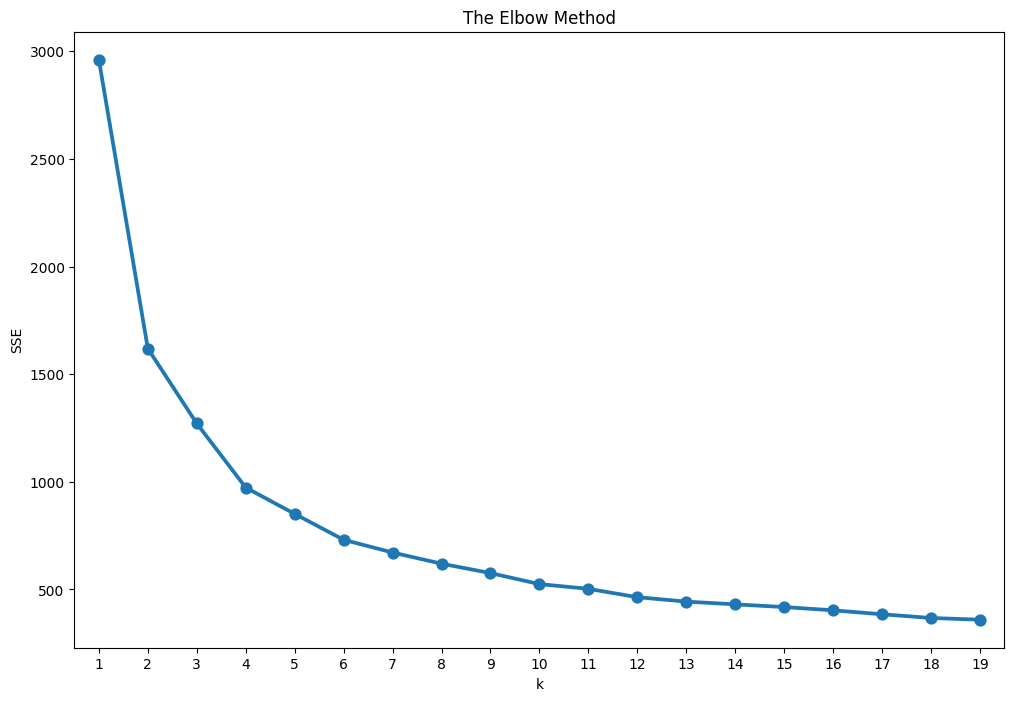

In [ ]:
plt.figure(figsize=(12,8))

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
K = range(1, 20)

distortions = []
inertias = []
mapping1 = {}
sse = {}
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)

    distortions.append(sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / customers_normalized.shape[0])
    inertias.append(kmeans.inertia_)

    mapping1[k] = sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / customers_normalized.shape[0]

    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 1.5527015539608544
2 : 1.168302337513326
3 : 1.0323518236498934
4 : 0.9189051790683842
5 : 0.85655418974935
6 : 0.7944265480107766
7 : 0.7652399762188422
8 : 0.731894777043453
9 : 0.7058090285583887
10 : 0.6738032025886503
11 : 0.6586769658340583
12 : 0.6328618532407122
13 : 0.61755047521812
14 : 0.6082371889577218
15 : 0.5985238527649701
16 : 0.5873993352253978
17 : 0.5750859260940151
18 : 0.563792387291463
19 : 0.557617219597886


In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(987,)

In [ ]:
rfm.shape

(987, 4)

In [ ]:
rfm["Cluster"] = model.labels_
rfm.head()

,Customer ID,Recency,Frequency,MonetaryValue,Cluster
0,C001,51,7,246.42,0
1,C002,6,3,126.30,2
2,C003,25,5,217.36,0
3,C004,59,3,85.00,1
4,C005,58,5,202.26,0


In [ ]:
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          32.8       7.2         205.5   389
1          96.6       3.0          72.7   319
2          18.9       4.4         100.2   279

In [ ]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

rfm["Cluster"] = model.labels_
rfm.head()
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          21.5       7.8         220.0   286
1         105.9       2.3          47.7   184
2          14.8       4.3          94.5   228
3          68.7       4.8         131.0   289

In [ ]:
rfm_fig = rfm.copy()

#Remove the outlier for visualization
y1 = rfm_fig['Frequency']
size = rfm_fig.shape[0]
removed_outliers = y1.between(y1.quantile(.05), y1.quantile(.95))
print(str(y1[removed_outliers].size) + "/" + str(size) + " data points remain.")
index_names = rfm_fig[~removed_outliers].index
rfm_fig.drop(index_names, inplace=True)

#Remove the outlier for visualization
y2 = rfm_fig['Recency']
size = rfm_fig.shape[0]
removed_outliers = y2.between(y2.quantile(.05), y2.quantile(.95))
print(str(y2[removed_outliers].size) + "/" + str(size) + " data points remain.")
index_names = rfm_fig[~removed_outliers].index
rfm_fig.drop(index_names, inplace=True)

#Remove the outlier for visualization
y3 = rfm_fig['MonetaryValue']
size = rfm_fig.shape[0]
removed_outliers = y3.between(y3.quantile(.05), y3.quantile(.95))
print(str(y3[removed_outliers].size) + "/" + str(size) + " data points remain.")
index_names = rfm_fig[~removed_outliers].index
rfm_fig.drop(index_names, inplace=True)

906/987 data points remain.
824/906 data points remain.
740/824 data points remain.


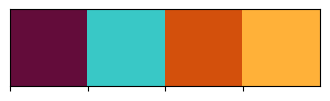

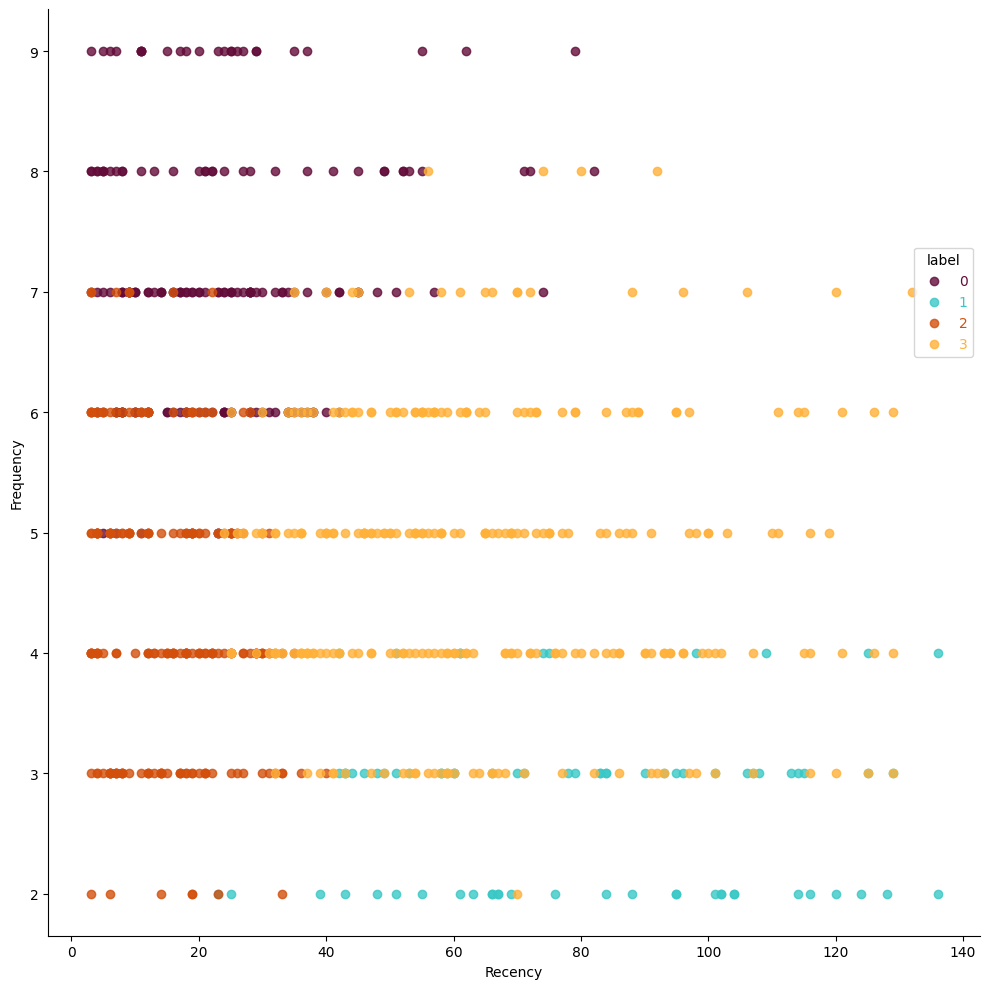

In [ ]:
#define a custom palette
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)

data = pd.DataFrame(data=rfm_fig,columns=['Customer ID','Cluster','Recency','Frequency','MonetaryValue'])

#plot data with seaborn (don't add a legend yet)
facet = sns.lmplot(data=data, x='Recency', y='Frequency', hue='Cluster', height=10,
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)
#change colors of labels
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])

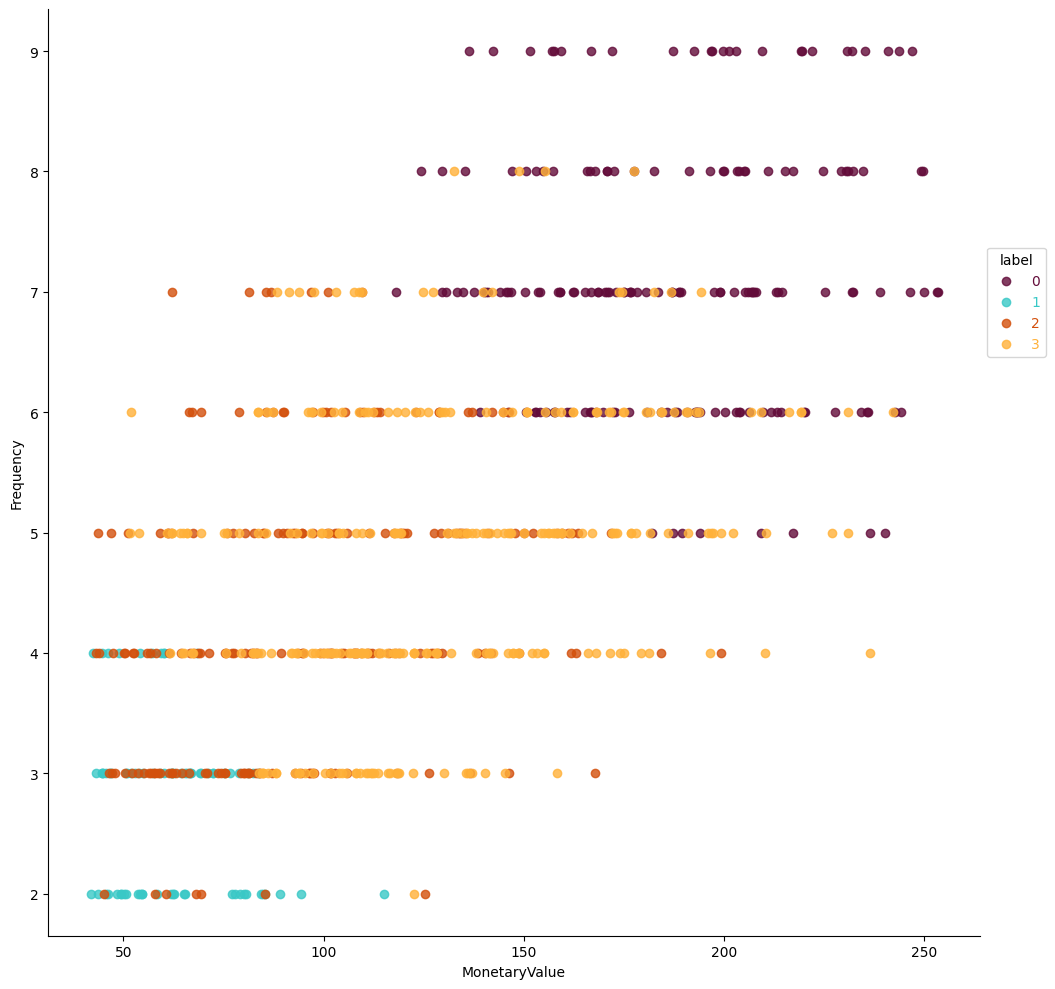

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 8))
#plot data with seaborn (don't add a legend yet)
facet = sns.lmplot(data=data, x='MonetaryValue', y='Frequency', hue='Cluster', height=10,
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)
#change colors of labels
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])

In [ ]:
rfm_fig['Cluster'] = rfm_fig['Cluster'].astype(str)

import plotly.express as px
fig = px.scatter_3d(rfm_fig,x='Recency', y='Frequency', z='MonetaryValue',
              color='Cluster', opacity=0.7,color_discrete_sequence=px.colors.qualitative.G10)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
cluster_avg = rfm[['Cluster','Recency','Frequency','MonetaryValue']].groupby(['Cluster']).mean()
population_avg = rfm[['Recency','Frequency','MonetaryValue']].head().mean()

In [ ]:
cluster_avg

,Recency,Frequency,MonetaryValue
Cluster,,,
0,21.468531,7.755245,220.035594
1,105.945652,2.298913,47.657446
2,14.798246,4.298246,94.476140
3,68.709343,4.771626,130.979343


In [ ]:
population_avg

,0
Recency,39.800
Frequency,4.600
MonetaryValue,175.468


In [ ]:
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.46,0.69,0.25
1,1.66,-0.50,-0.73
2,-0.63,-0.07,-0.46
3,0.73,0.04,-0.25


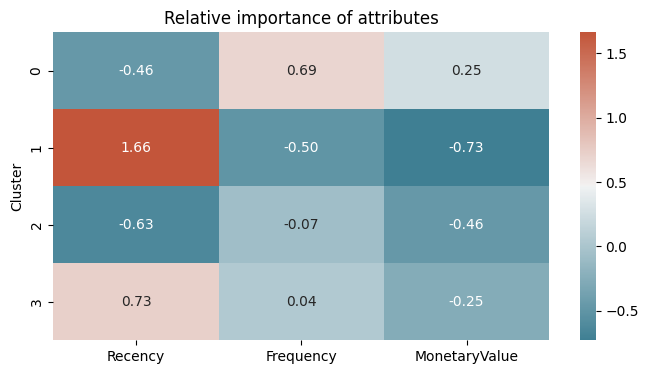

In [ ]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# Plot heatmap
plt.figure(figsize=(8, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap=cmap)
plt.show()

In [ ]:
# Create the quartiles scores
quantiles = rfm[['Recency', 'Frequency', 'MonetaryValue']].quantile(q=[0.2,0.4,0.6,0.8])
quantiles = quantiles.to_dict()

def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]:
        return 3
    elif x <= d[p][0.8]:
        return 2
    else:
        return 1

def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]:
        return 3
    elif x <= d[p][0.8]:
        return 4
    else:
        return 5

rfm['R'] = rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm['F'] = rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm['M'] = rfm['MonetaryValue'].apply(FMScore, args=('MonetaryValue',quantiles,))

In [ ]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment'] = rfm.apply(join_rfm, axis=1)
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

In [ ]:
rfm['RFM_Segment'].unique()

array(['245', '513', '435', '212', '235', '433', '422', '134', '113',
       '412', '444', '555', '434', '121', '222', '532', '211', '323',
       '145', '111', '355', '423', '321', '112', '223', '122', '411',
       '123', '544', '233', '343', '234', '511', '132', '533', '244',
       '521', '311', '224', '512', '455', '545', '421', '344', '534',
       '333', '523', '114', '335', '322', '413', '313', '445', '221',
       '442', '345', '155', '232', '354', '443', '535', '255', '514',
       '554', '542', '522', '324', '243', '142', '213', '424', '312',
       '334', '124', '453', '454', '225', '524', '531', '431', '135',
       '543', '332', '353', '425', '432', '254', '553', '115', '144',
       '133', '231', '331', '342', '143', '125', '214', '253', '242',
       '131', '154', '541'], dtype=object)

In [ ]:
# Create human friendly RFM labels
segt_map = {

    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At risk',
    r'[1-2]5': 'Can\'t lose them',
    r'3[1-2]': 'About to sleep',
    r'33': 'Need attention',
    r'[3-4][4-5]': 'Loyal customers',
    r'41': 'Promising',
    r'51': 'New customers',
    r'[4-5][2-3]': 'Potential loyalists',
    r'5[4-5]': 'Champions'
}
# rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)+ rfm['M'].map(str)
rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
# Create some human friendly labels for the scores
rfm['Score'] = 'Green'
rfm.loc[rfm['RFM_Score']>5,'Score'] = 'Bronze'
rfm.loc[rfm['RFM_Score']>7,'Score'] = 'Silver'
rfm.loc[rfm['RFM_Score']>9,'Score'] = 'Gold'
rfm.loc[rfm['RFM_Score']>10,'Score'] = 'Platinum'
# List the head of the table to view the
rfm.head(5)

,Customer ID,Recency,Frequency,MonetaryValue,Cluster,R,F,M,RFM_Segment,RFM_Score,Segment,Score
0,C001,51,7,246.42,0,2,4,5,245,11,At risk,Platinum
1,C002,6,3,126.30,2,5,1,3,513,9,New customers,Silver
2,C003,25,5,217.36,0,4,3,5,435,12,Potential loyalists,Platinum
3,C004,59,3,85.00,3,2,1,2,212,5,Hibernating,Green
4,C005,58,5,202.26,3,2,3,5,235,10,At risk,Gold


In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [ ]:
rfm.head()

,Customer ID,Recency,Frequency,MonetaryValue,Cluster,R,F,M,RFM_Segment,RFM_Score,Segment,Score
0,C001,51,7,246.42,0,2,4,5,245,11,At risk,Platinum
1,C002,6,3,126.30,2,5,1,3,513,9,New customers,Silver
2,C003,25,5,217.36,0,4,3,5,435,12,Potential loyalists,Platinum
3,C004,59,3,85.00,3,2,1,2,212,5,Hibernating,Green
4,C005,58,5,202.26,3,2,3,5,235,10,At risk,Gold


In [ ]:
fig1 = rfm.groupby(['Segment']).count().unstack().fillna(0)
fig2 = rfm.groupby(['Score']).count().unstack().fillna(0)

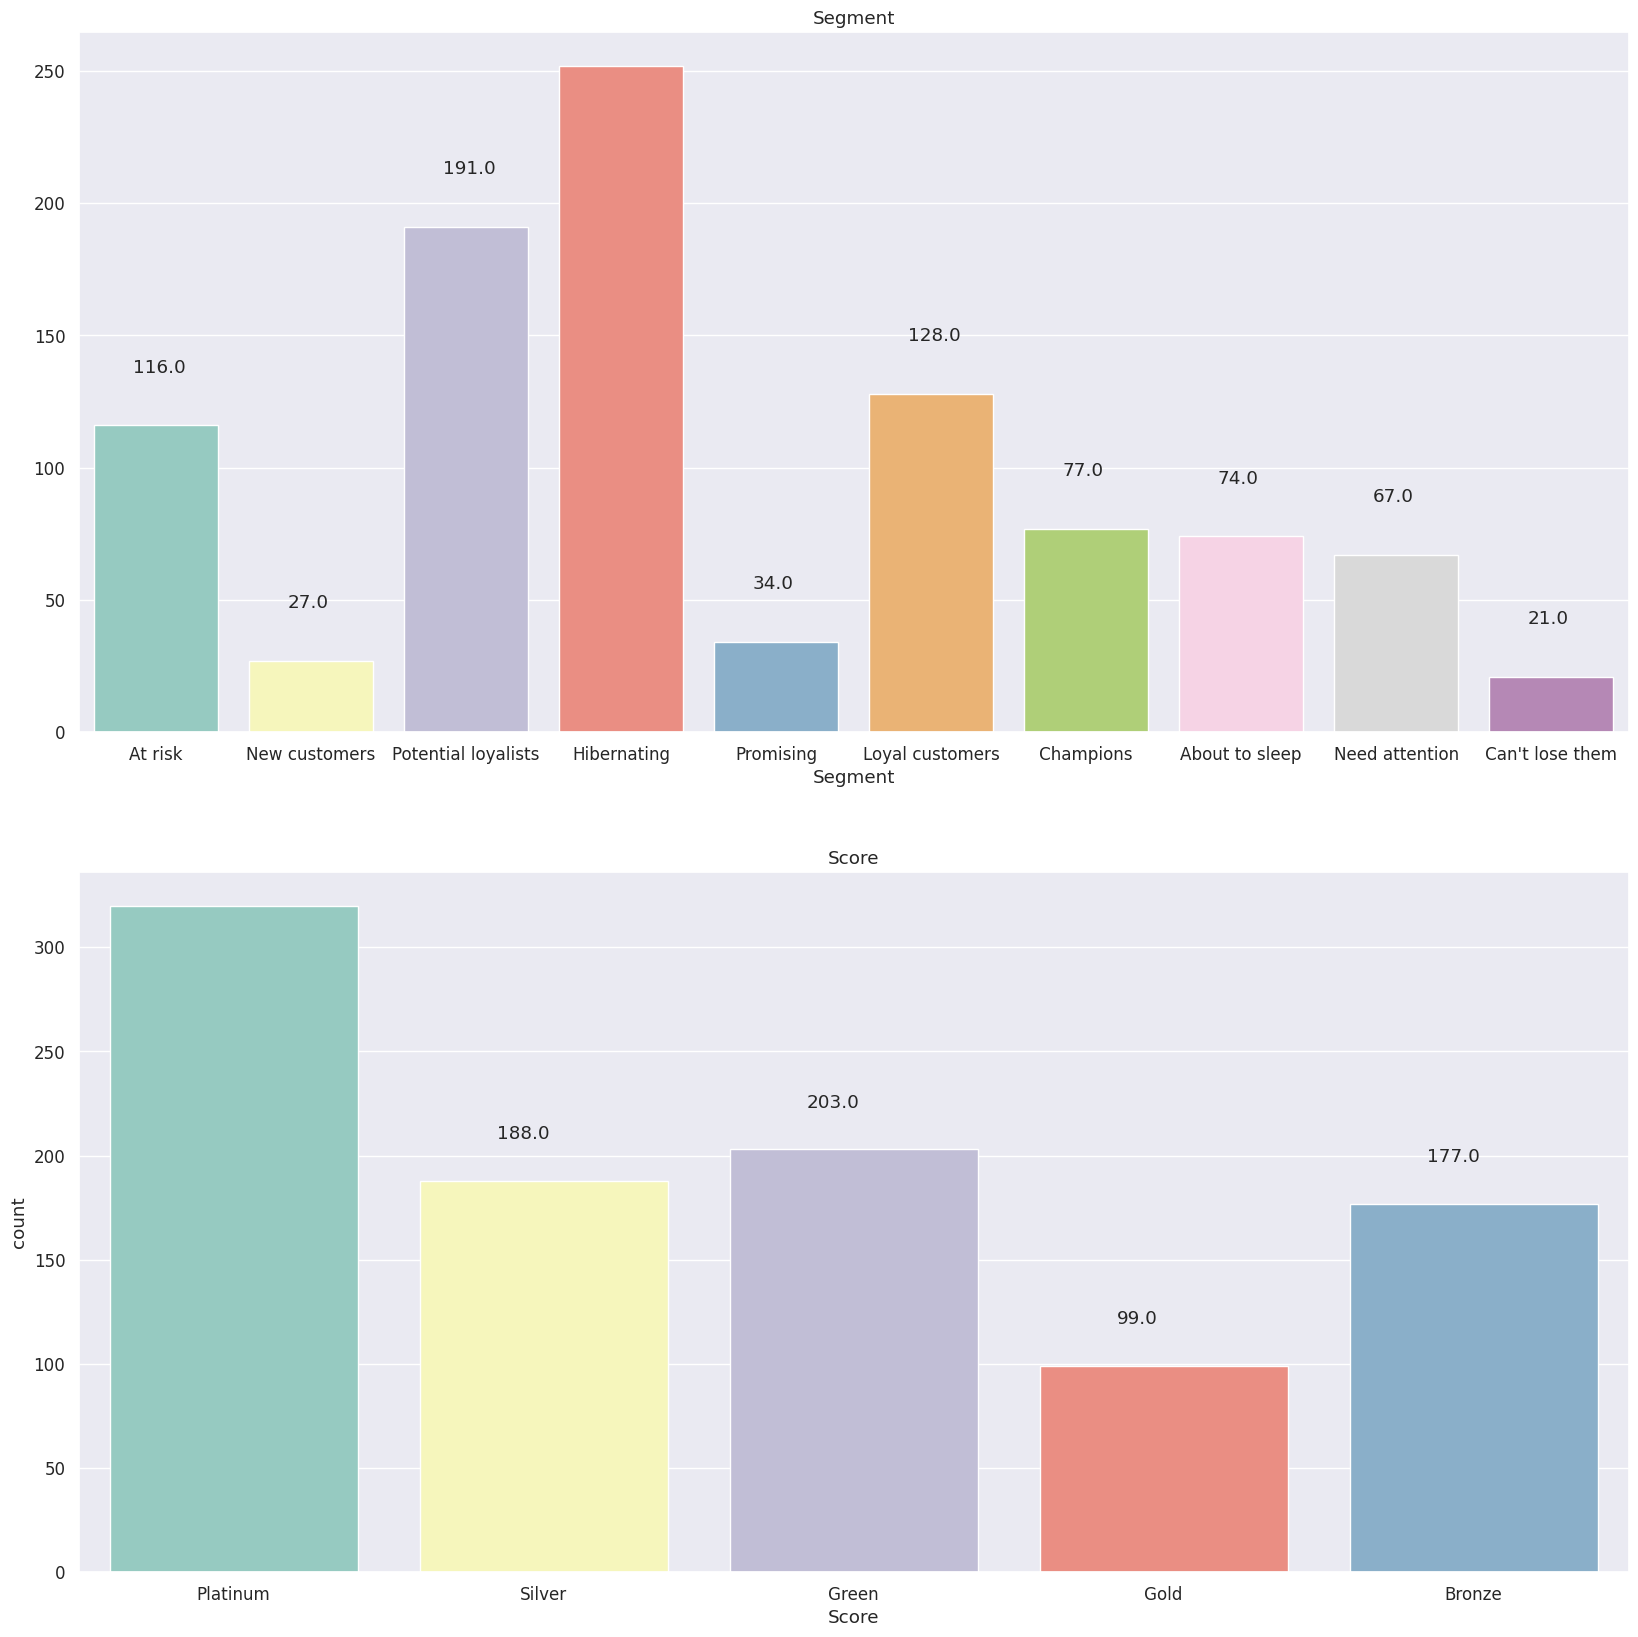

In [ ]:
import matplotlib.pyplot as plt

sns.set(font_scale=1.1)

# Pie Chart
f, ax = plt.subplots(2, 1, figsize=(20, 20))
# Pass 'Segment' as the 'x' argument and rfm as the 'data' argument.
sns.countplot(x='Segment', data=rfm, ax=ax[0], palette="Set3")
ax[0].set_title('Segment')
ax[0].set_ylabel('')
# Removed the duplicate title setting
# ax[0].set_title('Survival count by IsAlone')
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

# Bar chart - count
# Pass 'Score' as the 'x' argument and rfm as the 'data' argument.
sns.countplot(x='Score', data=rfm, ax=ax[1], palette="Set3")
ax[1].set_title('Score')

for p in ax[0].patches:
    ax[0].annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 20))

for p in ax[1].patches:
    ax[1].annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 20))

plt.show()

In [ ]:
# Aggregate data by each customer
fig3 = rfm.groupby('Segment').agg({'Customer ID': lambda x: len(x)}).reset_index()

# Rename columns
fig3.rename(columns={'Customer ID': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)

fig3.head()

,Segment,Count,percent
0,About to sleep,74,7.5
1,At risk,116,11.8
2,Can't lose them,21,2.1
3,Champions,77,7.8
4,Hibernating,252,25.5


In [ ]:
#Creating a Treemap with Plotly Express
# colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c'] #color palette
colors=['#83af70','#9fbf8f','#bad0af','#d5e0cf','#f1f1f1','#f1d4d4','#f0b8b8','#ec9c9d'] #color palette
import plotly.express as px

fig = px.treemap(fig3, path=['Segment'],values='Count'
                 , width=800, height=400
                 ,title="RFM Segments")

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

In [ ]:
# Aggregate data by each customer
fig4 = rfm.groupby('Score').agg({'Customer ID': lambda x: len(x)}).reset_index()


# Rename columns
fig4.rename(columns={'Customer ID': 'Count'}, inplace=True)
fig4['percent'] = (fig4['Count'] / fig4['Count'].sum()) * 100
fig4['percent'] = fig4['percent'].round(1)

fig4.head()

,Score,Count,percent
0,Bronze,177,17.9
1,Gold,99,10.0
2,Green,203,20.6
3,Platinum,320,32.4
4,Silver,188,19.0


In [ ]:
#Creating a Treemap with Plotly Express
# colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c'] #color palette
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4'] #color palette
import plotly.express as px

fig = px.treemap(fig4, path=['Score'],values='Count'
                 , width=800, height=400
                 ,title="Treemap of RFM Score")

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

In [ ]:
# Aggregate data by each customer
fig5 = rfm.groupby(['Cluster', 'Segment', 'Score']).agg({'Customer ID': lambda x: len(x)}).reset_index()

# Rename columns
fig5.rename(columns={'Customer ID': 'Count'}, inplace=True)
fig5['percent'] = (fig5['Count'] / fig5['Count'].sum()) * 100
fig5['percent'] = fig5['percent'].round(1)

fig5.head()
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4'] #color palette
import plotly.express as px
fig = px.treemap(fig5, path=[px.Constant("Customer"), 'Cluster', 'Segment', 'Score'], values='Count'
                ,title="Treemap of Customer Segment")
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

In [ ]:
# Aggregate data by each customer
rfm1 = rfm.groupby(['Cluster','Segment'],).agg({'Customer ID': lambda x: len(x)}).reset_index()

# Rename columns
rfm1.rename(columns={'Customer ID': 'Count'}, inplace=True)
rfm1['percent'] = (rfm1['Count'] / rfm1.groupby('Cluster')['Count'].transform('sum')) * 100
rfm1['percent'] = rfm1['percent'].round(1)

rfm1

,Cluster,Segment,Count,percent
0,0,At risk,5,1.7
1,0,Can't lose them,17,5.9
2,0,Champions,71,24.8
3,0,Loyal customers,122,42.7
4,0,Need attention,18,6.3
5,0,Potential loyalists,53,18.5
6,1,About to sleep,19,10.3
7,1,Hibernating,156,84.8
8,1,Promising,9,4.9
9,2,About to sleep,25,11.0
